# Band gap prediction 
This notebook uses the expdf_mergetal data of  [Zhau et al.](https://pubs.acs.org/doi/10.1021/acs.jpclett.8b00124) on predicting the band gap. 

In [259]:
%matplotlib inline
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from matminer.featurizers.conversions import StrToComposition
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, ShuffleSplit, KFold

import matplotlib.gridspec as gridspec
from datetime import datetime
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from sklearn.linear_model import ElasticNetCV, ElasticNet, LassoCV,Lasso, RidgeCV, Ridge, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor, StackingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import matplotlib.style as style
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings('ignore')

### Download the Data
We download the experimental data provided in the paper [Zhau et al.](https://pubs.acs.org/doi/10.1021/acs.jpclett.8b00124)

In [20]:
#read file
data = pd.read_excel('/home/dima/Desktop/ML/Band_gaps_data/jz8b00124_si_002.xlsx')

Let's see what we have

In [21]:
data.describe()

,Eg (eV)
count,6354.000000
mean,1.252162
std,1.539951
min,0.000000
25%,0.000000
50%,0.710000
75%,2.129750
max,11.700000


Rename the columns to make the rest of the code more succinct

In [22]:
data = data.rename(columns={'Eg (eV)': 'E'})

Make all the `E` values to be numeric

In [23]:
for k in ['E']:
    data[k] = pd.to_numeric(data[k])

Drop all the NaN's

In [35]:
original_count = len(data)
data.dropna(subset=['E'], inplace=True)
print('Removed %d/%d entries'%(original_count - len(data), original_count))

Removed 0/6339 entries


So, there is now null data in 'E'

Reindex the data

In [25]:
data.index = np.arange(len(data))

There are many duplicated compounds with a bit different values of band gaps. 
These probably correspond to different mesaurments.
We repalce duplicates by mean values

In [26]:
%%time
for i in range(0,len(data)):
    p=1
    for k in range(i+1,len(data)):
        if data['composition'][i]==data['composition'][k]:
            data['E'][i] += data['E'][k]
            p+=1
        if k==(len(data)-1):
            data['E'][i]=data['E'][i]/p

CPU times: user 7min, sys: 0 ns, total: 7min
Wall time: 7min


In [38]:
original_count = len(data)
data.drop_duplicates('composition', keep='first', inplace=True)
print('Removed %d/%d entries'%(original_count - len(data), original_count))

Removed 0/4930 entries


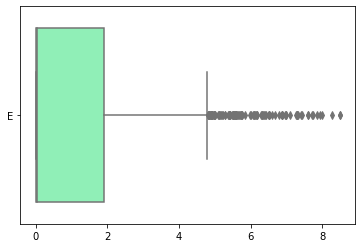

In [39]:
# See the outliers
sns.boxplot(data=data, palette='rainbow', orient='h');

Remove outliers: remove all the compounds with band gap greater then 9

In [40]:
original_count = len(data)
data = data[np.logical_and(data['E'] >= 0, data['E'] <= 9)]
print('Removed %d/%d entries'%(original_count - len(data), original_count))

Removed 0/4930 entries


Save the data

In [41]:
data.to_csv('reworked_data.csv', header=True, index=False)

## Feauture generating
Here we will generate features starting from soichiometry only.

In [153]:
data = pd.read_csv("/home/dima/Desktop/ML/Data/reworked_data_bandgap.csv")

In [154]:
data.head()

,composition,E
0,Hg0.7Cd0.3Te,0.310000
1,CuBr,2.998325
2,LuP,1.300000
3,Cu3SbSe4,0.355000
4,ZnO,3.402809


Create new column 'formula' which is a list of the elements of a given compound. It will be needed further for feature generation 

In [155]:
data = StrToComposition(target_col_id='formula').featurize_dataframe(data, 'composition',  ignore_errors=True)

Drop all the NaN's in 'formula'

In [156]:
original_count = len(data)
data.dropna(subset=['formula'], inplace=True)
print('Removed %d/%d entries'%(original_count - len(data), original_count))

Removed 323/4930 entries


Generate features with matminer featurizer with 'magpie' preset

In [157]:
from matminer.featurizers.composition import ElementProperty
feature_calculators_magpie = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                                          cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])
feature_labels_magpie = feature_calculators_magpie.feature_labels()
df_magpie = feature_calculators_magpie.featurize_dataframe(data, col_id='formula', ignore_errors=True)

In [158]:
df_magpie.head()

,composition,E,formula,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,MagpieData minimum Number,...,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber,avg s valence electrons,avg p valence electrons,avg d valence electrons,avg f valence electrons,compound possible,max ionic char,avg ionic char
0,Hg0.7Cd0.3Te,0.310000,"(Hg, Cd, Te)",3,0.628490,0.555320,0.515994,0.505699,0.501395,48.0,...,163.200,11.200,152.0,2.000,2.000,10.0,4.9,True,0.041154,0.004770
1,CuBr,2.998325,"(Cu, Br)",2,0.707107,0.629961,0.574349,0.552045,0.535887,29.0,...,144.500,80.500,64.0,1.500,2.500,10.0,0.0,False,0.244896,0.061224
2,LuP,1.300000,"(Lu, P)",2,0.707107,0.629961,0.574349,0.552045,0.535887,15.0,...,98.000,96.000,2.0,2.000,1.500,0.5,7.0,True,0.190712,0.047678
3,Cu3SbSe4,0.355000,"(Cu, Sb, Se)",3,0.637377,0.564295,0.521836,0.509034,0.502747,29.0,...,112.125,98.125,14.0,1.625,2.375,10.0,0.0,False,0.100238,0.022844
4,ZnO,3.402809,"(Zn, O)",2,0.707107,0.629961,0.574349,0.552045,0.535887,8.0,...,103.000,91.000,12.0,2.000,2.000,5.0,0.0,True,0.551131,0.137783


Data now includes space group number (minimum, maximum, avarage) which is useless. Drop space group data

In [159]:
dropcol_magpie = ['MagpieData minimum SpaceGroupNumber','MagpieData maximum SpaceGroupNumber','MagpieData range SpaceGroupNumber', 'MagpieData mean SpaceGroupNumber', 'MagpieData avg_dev SpaceGroupNumber', 'MagpieData mode SpaceGroupNumber']
df_magpie=df_magpie.drop(columns = dropcol_magpie)
for i in dropcol_magpie:
    feature_labels_magpie.remove(i)  

Generate features with 'deml' preset

In [160]:
from matminer.featurizers.composition import ElementProperty

ep_feat = ElementProperty.from_preset(preset_name="deml")
df_deml = ep_feat.featurize_dataframe(data, col_id="formula", ignore_errors=True)  # input the "composition" column to the featurizer
feature_calculators_deml = ep_feat.feature_labels()
dropcol_deml = ['DemlData minimum atom_num','DemlData maximum atom_num',
 'DemlData range atom_num',
 'DemlData mean atom_num',
 'DemlData std_dev atom_num',
 'DemlData minimum atom_mass',
 'DemlData maximum atom_mass',
 'DemlData range atom_mass',
 'DemlData mean atom_mass',
 'DemlData std_dev atom_mass',
 'DemlData minimum row_num',
 'DemlData maximum row_num','DemlData range row_num', 'DemlData mean row_num', 'DemlData std_dev row_num', 'DemlData minimum col_num', 'DemlData maximum col_num','DemlData range col_num','DemlData mean col_num', 'DemlData std_dev col_num',
'DemlData minimum melting_point',
'DemlData maximum melting_point',
'DemlData range melting_point',
'DemlData mean melting_point',
'DemlData std_dev melting_point',
'DemlData minimum electronegativity',
'DemlData maximum electronegativity',
'DemlData range electronegativity',
'DemlData mean electronegativity',
'DemlData std_dev electronegativity']
df_deml = df_deml.drop(columns=dropcol_deml)

Merge 'magpie' and 'deml' features 

In [235]:
df_merge = pd.merge(df_magpie, df_deml)
df_merge

,composition,E,formula,0-norm,2-norm,3-norm,5-norm,7-norm,10-norm,MagpieData minimum Number,...,DemlData minimum mus_fere,DemlData maximum mus_fere,DemlData range mus_fere,DemlData mean mus_fere,DemlData std_dev mus_fere,DemlData minimum FERE correction,DemlData maximum FERE correction,DemlData range FERE correction,DemlData mean FERE correction,DemlData std_dev FERE correction
0,Hg0.7Cd0.3Te,0.310000,"(Hg, Cd, Te)",3,0.628490,0.555320,0.515994,0.505699,0.501395,48.0,...,-3.250341,-0.123616,3.126725,-1.752436,1.934341,-0.110341,0.350000,0.460341,0.055564,0.226597
1,CuBr,2.998325,"(Cu, Br)",2,0.707107,0.629961,0.574349,0.552045,0.535887,29.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,LuP,1.300000,"(Lu, P)",2,0.707107,0.629961,0.574349,0.552045,0.535887,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Cu3SbSe4,0.355000,"(Cu, Sb, Se)",3,0.637377,0.564295,0.521836,0.509034,0.502747,29.0,...,-4.286226,-1.972581,2.313645,-3.050496,1.124909,-0.166226,0.057419,0.223645,-0.034246,0.100252
4,ZnO,3.402809,"(Zn, O)",2,0.707107,0.629961,0.574349,0.552045,0.535887,8.0,...,-4.760000,-0.840000,3.920000,-2.800000,2.771859,0.230000,0.430000,0.200000,0.330000,0.141421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4602,ScCoO3,0.000000,"(Sc, Co, O)",3,0.663325,0.614463,0.600984,0.600078,0.600002,8.0,...,-4.760000,-4.630242,0.129758,-4.732918,0.068666,-0.104349,0.489758,0.594106,0.215082,0.252240
4603,Tm2MgTl,0.000000,"(Tm, Mg, Tl)",3,0.612372,0.538609,0.506099,0.501109,0.500098,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4604,Nb5Ga4,0.000000,"(Nb, Ga)",2,0.711458,0.637644,0.587958,0.570873,0.561251,31.0,...,-6.686752,-2.370000,4.316752,-4.768195,3.052404,0.353248,0.660000,0.306752,0.489582,0.216906
4605,Tb2Sb5,0.000000,"(Tb, Sb)",2,0.769309,0.729210,0.715743,0.714453,0.714293,51.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Feauture engineering

We now turn to the feature enegenering. Define some useful functions

In [138]:
#This function takes a DataFrame as input and returns two columns, total missing values and total missing values percentage
def missing_percentage(df):
    total = df.isnull().sum().sort_values(ascending = False)[df.isnull().sum().sort_values(ascending = False) != 0]
    percent = round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2)[round(df.isnull().sum().sort_values(ascending = False)/len(df)*100,2) != 0]
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])

In [139]:
#Drop all the columns with missing percent greater than "threshold"
def drop_missing(df, threshold=3):
    dropped = []
    for i in range(0, len(missing_percentage(df).Percent.index)):
        if missing_percentage(df).Percent[i] > threshold:
            dropped.append(missing_percentage(df).Percent.index[i])
    df = df.drop(columns=dropped)
    print(dropped)
    return df

In [140]:
# List all the columns
def col(df):
    for i in df.columns:
        print(i)

Drop all the columns with missing percent greater than "threshold"

In [236]:
df_merge = drop_missing(df_merge, threshold=1)

['DemlData std_dev FERE correction', 'DemlData minimum mus_fere', 'DemlData mean FERE correction', 'DemlData minimum GGAU_Etot', 'DemlData maximum GGAU_Etot', 'DemlData range GGAU_Etot', 'DemlData mean GGAU_Etot', 'DemlData std_dev GGAU_Etot', 'DemlData maximum mus_fere', 'DemlData range mus_fere', 'DemlData mean mus_fere', 'DemlData std_dev mus_fere', 'DemlData minimum FERE correction', 'DemlData maximum FERE correction', 'DemlData range FERE correction', 'DemlData range electric_pol', 'DemlData maximum electric_pol', 'DemlData minimum electric_pol', 'DemlData mean electric_pol', 'DemlData std_dev electric_pol', 'DemlData std_dev heat_cap', 'DemlData minimum heat_cap', 'DemlData range heat_cap', 'DemlData mean heat_cap', 'DemlData maximum heat_cap', 'DemlData minimum heat_fusion', 'DemlData std_dev heat_fusion', 'DemlData mean heat_fusion', 'DemlData range heat_fusion', 'DemlData maximum heat_fusion', 'DemlData mean atom_radius', 'DemlData range atom_radius', 'DemlData maximum atom_ra

Remove entries with `NaN` or `infinite` features

In [237]:
original_count = len(df_merge)
df_merge = df_merge[~ df_merge[feature_labels_magpie].isnull().any(axis=1)]
print('Removed %d/%d entries'%(original_count - len(df_merge), original_count))

Removed 1/4607 entries


For the future use we define a list of features associated to the training data

In [ ]:
features = []
for col in df_merge.columns:
    features+=[str(col)]
to_remove = ['composition', 'E', 'formula', 'compound possible']
for i in to_remove:
    features.remove(i)

### Data normalisation

Algorithms work better when rhe data has [skewness](https://en.wikipedia.org/wiki/Skewness) close to zero and it is also normalized

In [219]:
## Fixing Skewed features using boxcox transformation. 
def fixing_skewness(df):
    """
    This function takes in a dataframe and return fixed skewed dataframe
    """
    ## Import necessary modules 
    from scipy.stats import skew
    from scipy.special import boxcox1p
    from scipy.stats import boxcox_normmax
    
    ## Getting all the data that are not of "object" type. 
    numeric_feats = df.dtypes[df.dtypes != "object"].index

    # Check the skew of all numerical features
    skewed_feats = df[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skewed_feats[abs(skewed_feats) > 0.5]
    skewed_features = high_skew.index

    for feat in skewed_features:
        df[feat] = boxcox1p(df[feat], boxcox_normmax(df[feat] + 1))
    print(skewed_features)
    return df

Define target and features data

In [ ]:
X = df_merge[features]
y = df_merge['E']

In [267]:
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
X = scaler.fit_transform(X)
X = pd.DataFrame(X)

## Machine learing models


Define rmse fucntion

In [143]:
# define cross validation strategy
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

Define kfold

In [88]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

For gridsearch we set lists of parameters

In [86]:
alphas_rid = [1.0,0.8,0.5,0.3,0.2,0.1,0.05,0.02,0.01,0.002]
alphas_las = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

In [244]:
params={'alpha': [25,10,4,2,1.0,0.8,0.5,0.3,0.2,0.1,0.05,0.02,0.01,0.002]}
rdg_reg = Ridge()
grid = GridSearchCV(rdg_reg,params,cv=kfolds,verbose = 1, scoring = 'neg_mean_squared_error')
grid.fit(X,y)

grid.best_params_

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    2.2s finished


{'alpha': 0.2}

In [246]:
ridge = Ridge(alpha=0.02)
score = rmse_cv(ridge, X, y)
print("Ridge: {:.4f} \n".format(score.mean()), datetime.now(), )

Ridge: 1.1898 
 2020-03-30 10:17:37.158106


In [247]:
params={'alpha': [25,10,4,2,1.0,0.8,0.5,0.3,0.2,0.1,0.05,0.02,0.01,0.002]}
rdg_reg = Lasso()
grid = GridSearchCV(rdg_reg,params,cv=kfolds,verbose = 1, scoring = 'neg_mean_squared_error')
grid.fit(X,y)

grid.best_params_

Fitting 10 folds for each of 14 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    8.8s finished


{'alpha': 0.002}

In [253]:
lasso = Lasso(alpha=0.002)
score = rmse_cv(lasso, X, y)
print("Lasso: {:.4f} \n".format(score.mean()), datetime.now(), )

Lasso: 1.1998 
 2020-03-30 10:23:49.861100


In [124]:
parametersGrid = {"max_iter": [100, 1000, 2000],
                      "alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                      "l1_ratio": np.arange(0.0, 1.0, 0.1)}

eNet = ElasticNet()
grid = GridSearchCV(eNet, parametersGrid, scoring='neg_mean_squared_error', cv=10)
grid.fit(X, y)

grid.best_params_

{'alpha': 1e-05, 'l1_ratio': 0.9, 'max_iter': 2000}

In [224]:
elasticnet = ElasticNet(max_iter=10000, alpha=0.00001, l1_ratio=0.9) 
score = rmse_cv(elasticnet,X,y)
print("Elastic Net: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

Elastic Net: nan (nan)
 2020-03-30 10:05:16.040009


In [97]:
param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)}
grid = GridSearchCV(SVR(kernel='rbf'), param_grid,  scoring='neg_mean_squared_error', cv=10)
grid.fit(X, y)
grid.best_params_

{'C': 1.0, 'gamma': 10.0}

In [251]:
grid = GridSearchCV(RandomForestRegressor(n_estimators=200, n_jobs=-1),
                     param_grid=dict(max_features=range(8,18)),
                     scoring='neg_mean_squared_error',cv=kfolds)
grid.fit(X, y)
grid.best_params_

{'max_features': 17}

In [252]:
randomforest = RandomForestRegressor(n_estimators=300, n_jobs=-1, max_features=17) 
score = rmse_cv(randomforest,X ,y)
print("Random Forest: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

Random Forest: 0.7760 (0.0955)
 2020-03-30 10:23:37.862587


In [250]:
xgboost = XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:squarederror', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)
score = rmse_cv(xgboost, X, y)
print("XGBoost: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

XGBoost: 0.7722 (0.1206)
 2020-03-30 10:21:51.549666


In [265]:
stack_gen = StackingRegressor(regressors=(randomforest, lasso, elasticnet, xgboost),
                                meta_regressor=xgboost)
score = rmse_cv(stack_gen,X ,y)
print("Stacking: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

Stacking: 0.7473 (0.1041)
 2020-03-30 10:40:59.582288


### Results

The best algorithm is stacking with mean rmse 0.74 . 